## Imports and Data load

In [126]:
%pip install sweetviz
%pip install scikit-learn==1.1.3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [127]:
import pandas as pd
import sweetviz as sv
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.utils import shuffle

from tqdm import tqdm
import matplotlib.pyplot as plt

In [128]:
train_data = pd.read_csv(r'C:\Users\SerKer\Projects\Titanic_ML\titanic\train.csv')
test_features = pd.read_csv(r'C:\Users\SerKer\Projects\Titanic_ML\titanic\test.csv')

test_target = pd.read_csv(r'C:\Users\SerKer\Projects\Titanic_ML\titanic\gender_submission.csv')

In [129]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [130]:
test_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## EDA

Let's write a simple function to quickly review data

In [131]:
def info_df(df):
    plt.figure(figsize=(15, 13))
    sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('------------------------------')
    print('| Первые 10 строчек датасета |')
    print('------------------------------')
    print(df.head(10))
    print('---------------------------------')
    print('| Последние 10 строчек датасета |')
    print('---------------------------------')
    print(df.tail(10))
    print('---------------------------')
    print('| Описательная статистика |')
    print('---------------------------')
    print(df.describe())
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    print('--------------------------')
    print('| Ковариационная матрица |')
    print('--------------------------')
    plt.show()
    

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
------------------------------
| Первые 10 строчек датасета |
------------------------------
   PassengerId  Survived  Pclass  \
0            1        

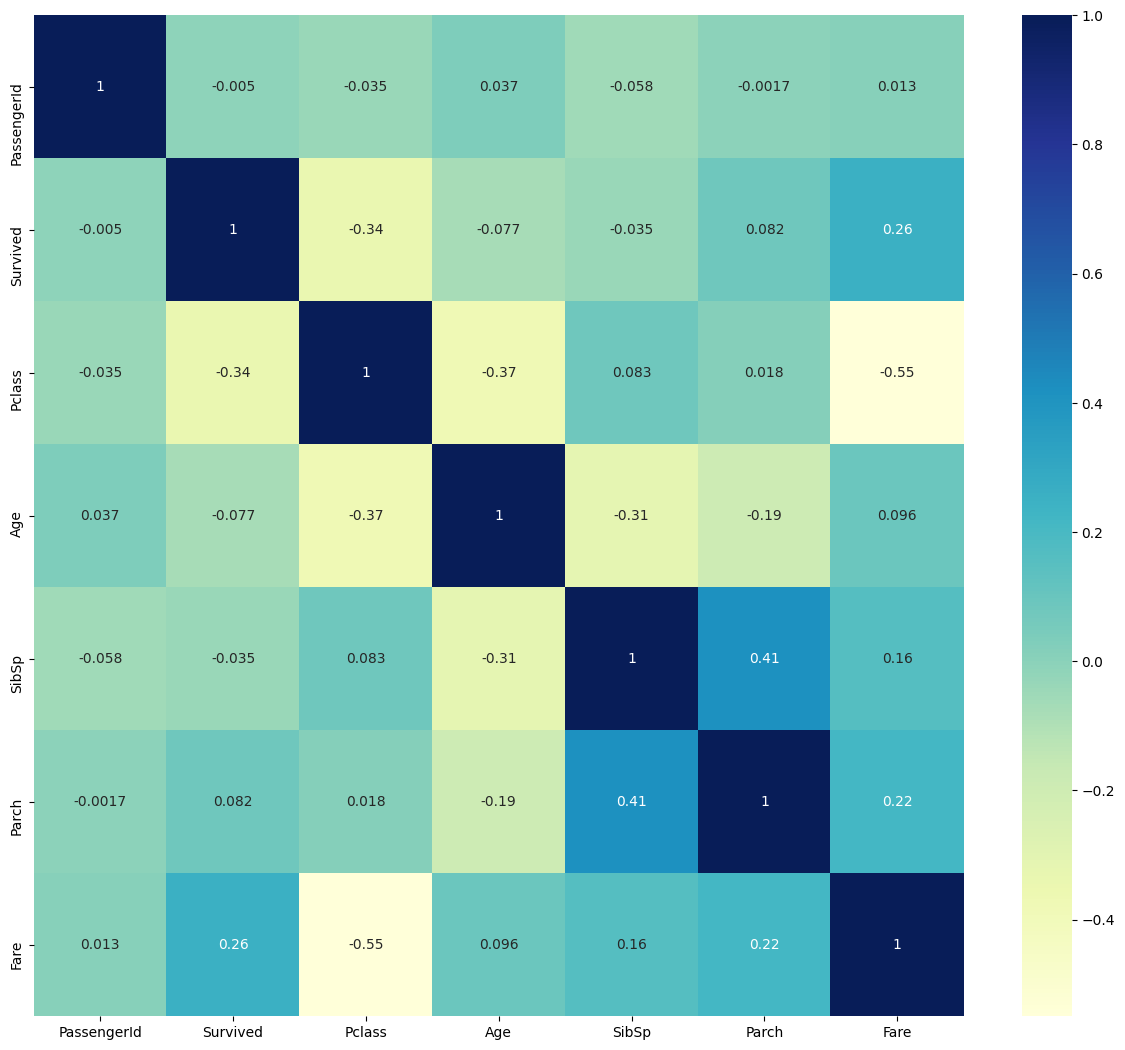

In [132]:
info_df(train_data)

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
------------------------------
| Первые 10 строчек датасета |
------------------------------
   PassengerId  Pclass                                          Name     Sex  \
0          892      

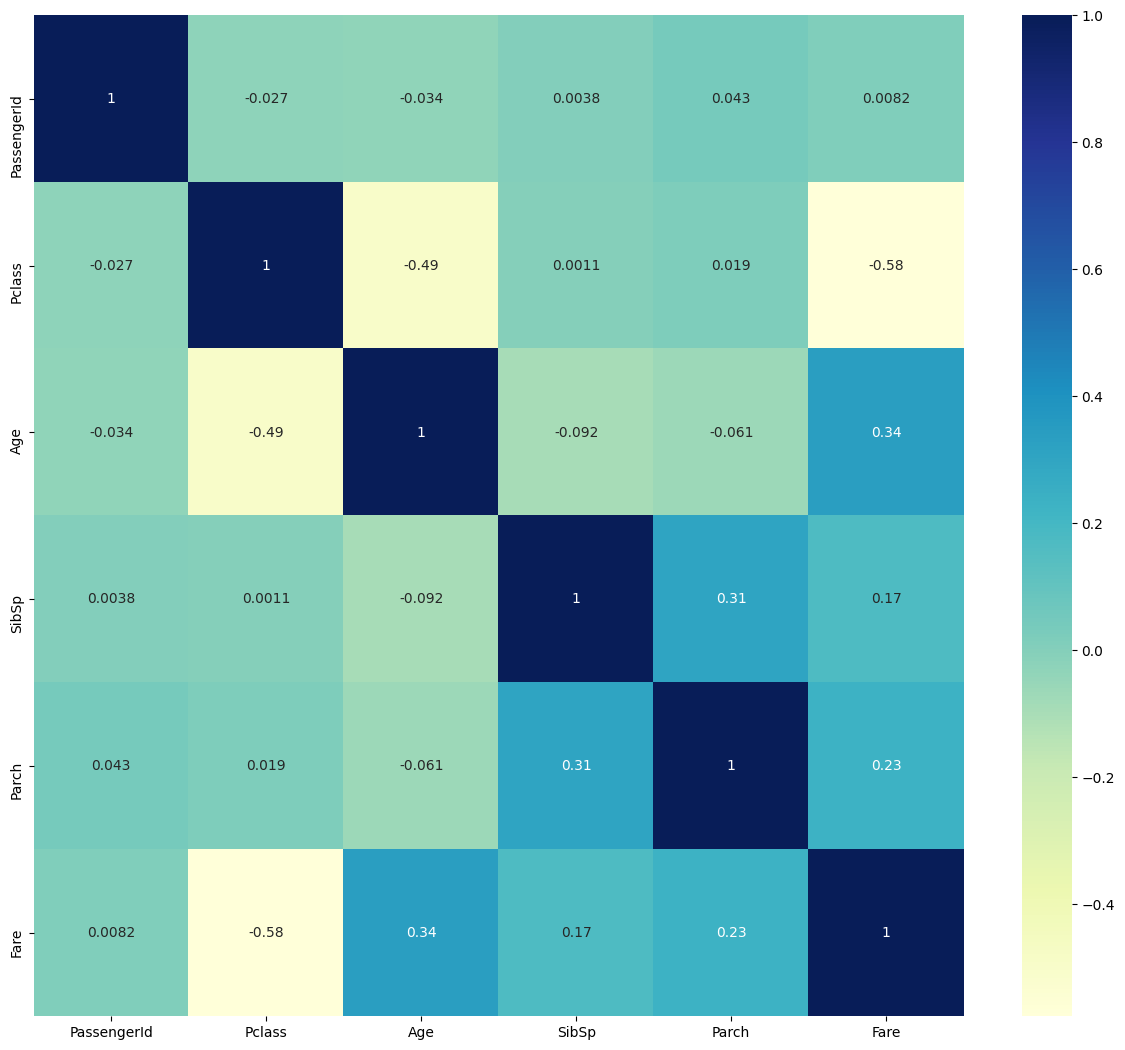

In [133]:
info_df(test_features)

We can see that in columns `Age`, `Cabin` and `Embarked` has a gaps in data. And also `Age` has a different data type (Float64). Let's make change to these mistakes!

**Rename titels**

In [134]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [135]:
columns = {}
for i in train_data.columns:
    columns[i] = i.lower()
train_data = train_data.rename(columns=columns)
test_features = test_features.rename(columns=columns)

**Duplicates**

In [136]:
train_data = train_data.drop('passengerid', axis = 1)
train_data.duplicated().sum()

0

In [137]:
test_features = test_features.drop('passengerid', axis = 1)
test_features.duplicated().sum()

0

**Implicit Duplicates**

Tickets

In [138]:
train_data['ticket'].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [139]:
ticket = {}
for i in train_data['ticket']:
    if ' ' in i:
        ticket[i] = i.split()[1]
train_data = train_data.apply(lambda x: x.replace(ticket, regex=True))
train_data = train_data.apply(lambda x: x.replace({'LINE' : '0', 'Basle' : '0', '2.' : '2'}, regex=True))
train_data['ticket'] = train_data['ticket'].astype('int64')



In [140]:
train_data['ticket'].unique()

array([   2171,   17599,  310122,  113803,  373450,  330877,   17463,
        349909,  347742,   27736,    9549,  113783,     251,  347082,
        350406,   28706,   38252,   24373,  345763,     249,   29865,
         28698,   33092,  113788,  347077,     231,   19950,  330959,
         34926,   17601,   17569,  335677,    2579,   17604,  113789,
           277,     252,  345764,    7546,   11668,   34923,      22,
        330958,    2567,  370371,   14311,     262,   34927,  310125,
         39886,   17572,  113509,   19947,    3102,     297,   34651,
           244,     269,  113572,   36973,  347088,   17605,     261,
          2395,    3464,  310121,  315151,   33111,   14879,     280,
          1601,   34812,   34928,  374746,   28738,  364516,  345767,
        345779,  330932,  113059,   14885,  310128,    6608,   39286,
         34325,   34326,  347466,    5734,     215,  364500,  374910,
         17754,   17759,   21919,   24367,   34925,    3521,    7540,
        310126,   34

**Fill in the blanks**

I think its not a big deal and we can fill blanks the median value.

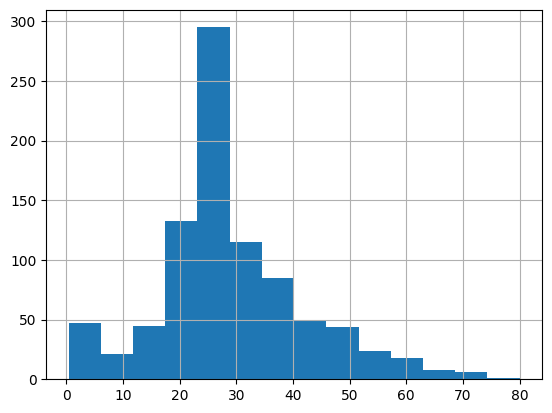

In [141]:
train_data['age'] = train_data['age'].fillna(train_data['age'].median())
train_data['age'].hist(bins=14);

**Cabin**

This point is ambiguous. Because the type of room really could affect survival. But we have a lot of gaps in this column. 

I suggest make a pivot table or just a look on dependency of data between type of room and passenger fare

In [144]:
train_data['cabin'].value_counts()

C12         9
D2          6
B2          6
A2          4
C2 C2 C2    4
           ..
C101        1
B42         1
A10         1
E36         1
E38         1
Name: cabin, Length: 133, dtype: int64

In [52]:
# Look a unique values for Cabin
train_data['Cabin'].unique()

# train_data = train_data.apply(lambda x: x.replace({'January':'1', 'February':'2', 
                                        #   'March':'3', 'April':'4',
                                        #   'May':'5', 'June':'6', 
                                        #   'July':'7', 'August':'8',
                                        #   'September':'9', 'October':'10',
                                        #   'November':'11','December':'12'}, regex=True))


# train_data[['Cabin', 'Fare']].value_counts(ascending=False)
#train_data.groupby('Cabin')['Fare'].count()

# pie = pd.DataFrame({'Количество заказов': [len(accepted), len(canceled)]})
    
# plot = pie.plot.pie(subplots=True, labels=['Приняты','Отказы'], autopct='%1.1f%%')

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Unique number type for `Cabin` - A, B, C, D, E, F, G, T. When we look on the row of `Cabins`, we can see double and triple mistakes (records) in one row. But for us it doesn't matter, because we are make masks for type of cabins.

In [ ]:
def room_masks(type_room: list) -> dict:
    return
# mask_A = train_data['Cabin'].str.startswith('A', na=False)
# mask_B = train_data['Cabin'].str.startswith('A', na=False)
# mask_A = train_data['Cabin'].str.startswith('A', na=False)

**Convert Float to Int**

In [13]:
train_data['Age'] = train_data['Age'].astype('int16')

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [12]:
train_report = sv.analyze(train_data)

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
train_report.show_html('Train_report.html')

Report Train_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
